In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd drive/MyDrive/hw3/

/content/drive/MyDrive/hw3


In [4]:
ls

discriminator.py  generator.py  images/       transforms.py  weights/
facades/          hw3.ipynb     __pycache__/  utils.py


In [5]:
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
from torchvision.utils import save_image

from discriminator import Discriminator
from generator import UnetGenerator
from transforms import Train_Transform, Val_Transform
from utils import weights_init, get_norm_layer



*   Дря реализации Pix2Pix пользовался [блогпостом](https://learnopencv.com/paired-image-to-image-translation-pix2pix/#disqus_thread).
*   Тестовая выборка была объеденина с трейном для увеличения датасета на 25%. Качество генератора оцениваем (визуально) на валидационной выборке.




In [6]:
BATCH_SIZE = 8

FACADES_PATH = "facades"
TRAIN_FOLDER = "train"
TRAIN_PATH = os.path.join(FACADES_PATH, 
                          TRAIN_FOLDER)

VAL_FOLDER = "val"
VAL_PATH = os.path.join(FACADES_PATH, 
                        VAL_FOLDER)

In [7]:
class FacadesDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        
    def __getitem__(self, index):
        image_name = str(index) + ".jpg"
        image_path = os.path.join(self.images_path, image_name)
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(os.listdir(self.images_path))
    
    def show(self, index):
        image_name = str(index) + ".jpg"
        image_path = os.path.join(self.images_path, image_name)
        x = Image.open(image_path)
        plt.imshow(x)
        plt.show()

In [8]:
train_dataset = FacadesDataset(images_path=TRAIN_PATH, 
                               transform=transforms.Compose([Train_Transform()]))
train_dataloader = DataLoader(train_dataset, BATCH_SIZE)

In [9]:
val_dataset = FacadesDataset(images_path=VAL_PATH, 
                             transform=transforms.Compose([Val_Transform()]))
val_dataloader = DataLoader(val_dataset, BATCH_SIZE)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
norm_layer = get_norm_layer()

In [12]:
generator = UnetGenerator(3, 3, 64,
                          norm_layer=norm_layer,
                          use_dropout=False)
generator.apply(weights_init)
generator = generator.to(device)

In [13]:
discriminator = Discriminator(6, 64, n_layers=3, norm_layer=norm_layer)
discriminator.apply(weights_init)
discriminator = discriminator.to(device)

In [14]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

In [15]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    return gen_total_loss

In [16]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [17]:
learning_rate = 2e-4 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [24]:
num_epochs = 70
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 
    D_loss_list, G_loss_list = [], []

    for input_img, target_img in train_dataloader:
        D_optimizer.zero_grad()

        input_img = input_img.to(device)
        target_img = target_img.to(device)
        
        generated_image = generator(input_img)
        
        disc_inp_fake = torch.cat((input_img, generated_image), 1)
        
        real_target = Variable(torch.ones(input_img.size(0), 1, 30, 30).to(device))
        fake_target = Variable(torch.zeros(input_img.size(0), 1, 30, 30).to(device))
        
        D_fake = discriminator(disc_inp_fake.detach())
        D_fake_loss   =  discriminator_loss(D_fake, fake_target)
        disc_inp_real = torch.cat((input_img, target_img), 1)
                                     
        output = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(output,  real_target)
      
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward()
        D_optimizer.step()
        
        
        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)                                 
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()
        
    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

    if epoch % 10 == 1:
      torch.save(generator.state_dict(), 'weights/generator_epoch_%d.pth' % (epoch))
      torch.save(discriminator.state_dict(), 'weights/discriminator_epoch_%d.pth' % (epoch))
    
    for idx, (inputs, targets) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        generated_output = generator(inputs)
        save_image(generated_output.data[:10], f"images/sample_{idx}_epoch_{epoch}.png", nrow=4, normalize=True)

torch.save(generator.state_dict(), 'weights/generator_epoch_%d.pth' % (epoch))
torch.save(discriminator.state_dict(), 'weights/discriminator_epoch_%d.pth' % (epoch))

Epoch: [1/70]: D_loss: 0.316, G_loss: 16.136
Epoch: [2/70]: D_loss: 0.325, G_loss: 16.346
Epoch: [3/70]: D_loss: 0.331, G_loss: 16.281
Epoch: [4/70]: D_loss: 0.371, G_loss: 16.075
Epoch: [5/70]: D_loss: 0.359, G_loss: 15.803
Epoch: [6/70]: D_loss: 0.564, G_loss: 15.611
Epoch: [7/70]: D_loss: 0.377, G_loss: 15.634
Epoch: [8/70]: D_loss: 0.359, G_loss: 15.552
Epoch: [9/70]: D_loss: 0.391, G_loss: 15.354
Epoch: [10/70]: D_loss: 0.448, G_loss: 15.076
Epoch: [11/70]: D_loss: 0.400, G_loss: 15.001
Epoch: [12/70]: D_loss: 0.423, G_loss: 14.980
Epoch: [13/70]: D_loss: 0.434, G_loss: 14.890
Epoch: [14/70]: D_loss: 0.426, G_loss: 14.758
Epoch: [15/70]: D_loss: 0.633, G_loss: 14.801
Epoch: [16/70]: D_loss: 0.454, G_loss: 14.563
Epoch: [17/70]: D_loss: 0.416, G_loss: 14.500
Epoch: [18/70]: D_loss: 0.418, G_loss: 14.485
Epoch: [19/70]: D_loss: 0.435, G_loss: 14.236
Epoch: [20/70]: D_loss: 0.472, G_loss: 14.154
Epoch: [21/70]: D_loss: 0.424, G_loss: 14.077
Epoch: [22/70]: D_loss: 0.667, G_loss: 14.0

In [19]:
generator.load_state_dict(torch.load('weights/generator_epoch_70.pth'))

<All keys matched successfully>

In [23]:
discriminator.load_state_dict(torch.load('weights/discriminator_epoch_70.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


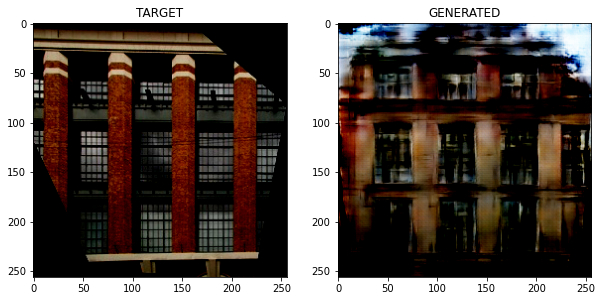

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


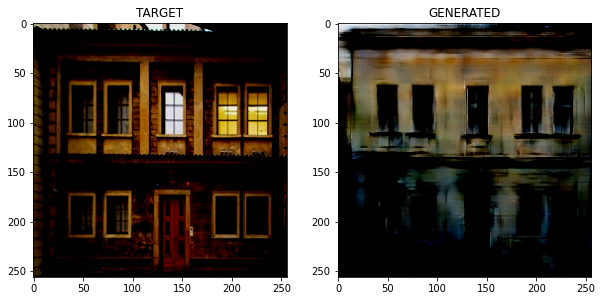

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


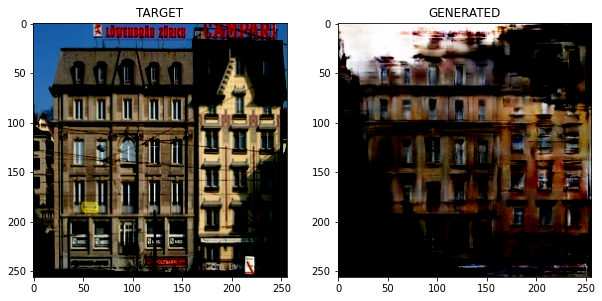

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


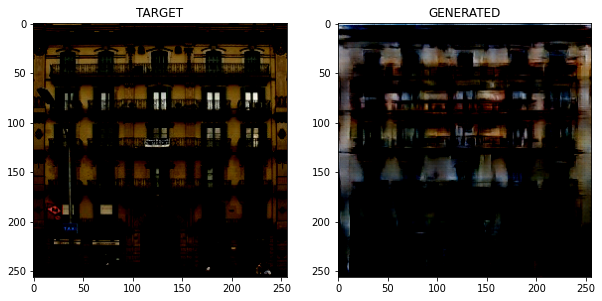

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


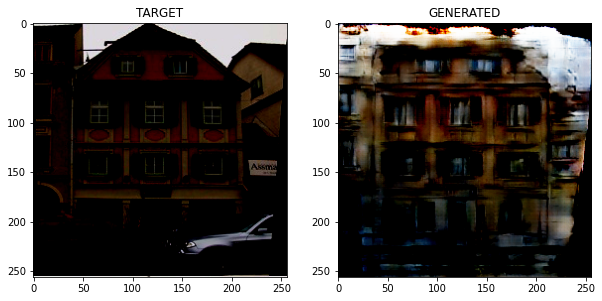

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


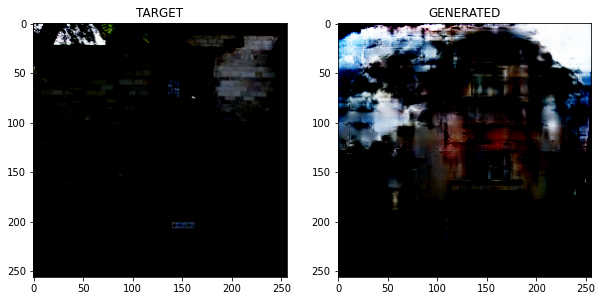

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


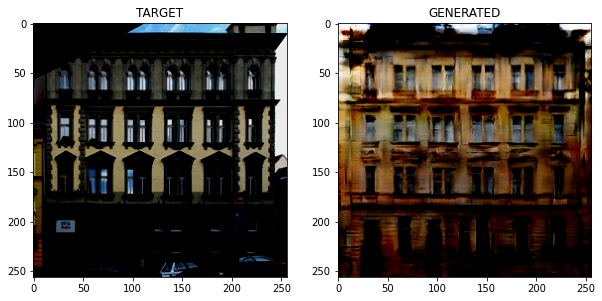

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


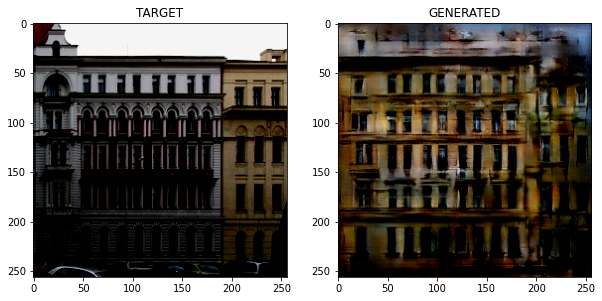

In [30]:
inputs, targets = next(iter(val_dataloader))
inputs = inputs.to(device)
generated_output = generator(inputs)

for target_image, generated_image  in zip(targets, generated_output):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(np.transpose(target_image, (1, 2, 0)))
  axs[0].set_title("TARGET")
  axs[0].grid(False)

  axs[1].imshow(np.transpose(generated_image.detach().cpu().numpy(), (1, 2, 0)))
  axs[1].set_title("GENERATED")
  axs[1].grid(False)

  plt.show()

In [31]:
generator.apply(weights_init)

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


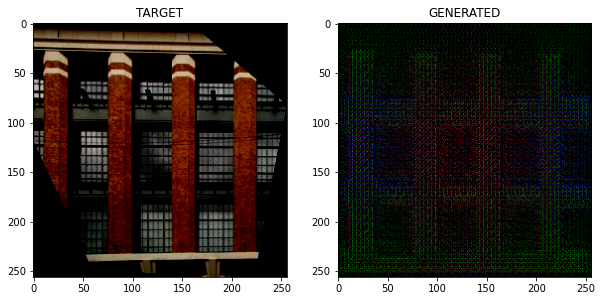

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


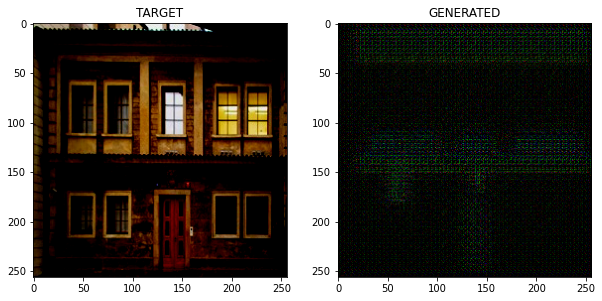

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


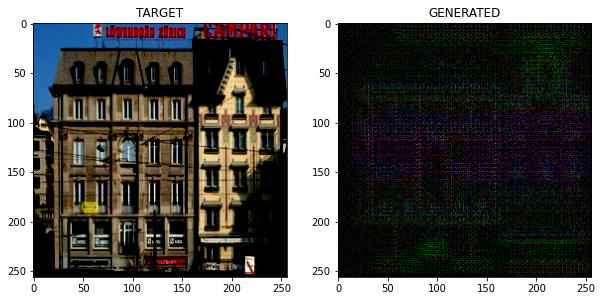

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


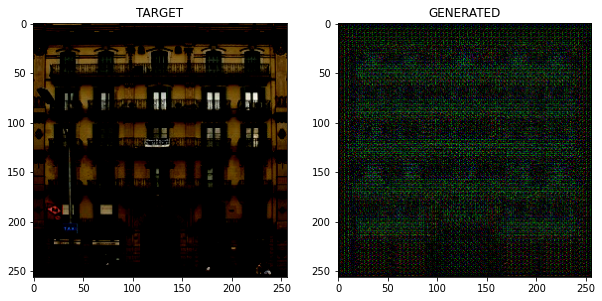

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


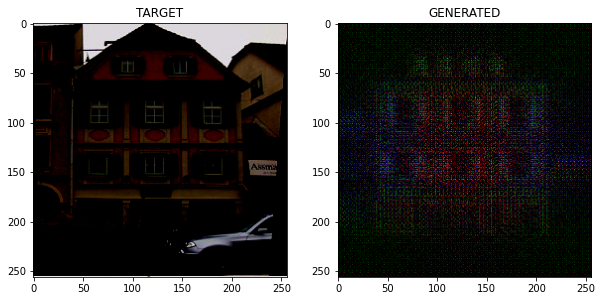

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


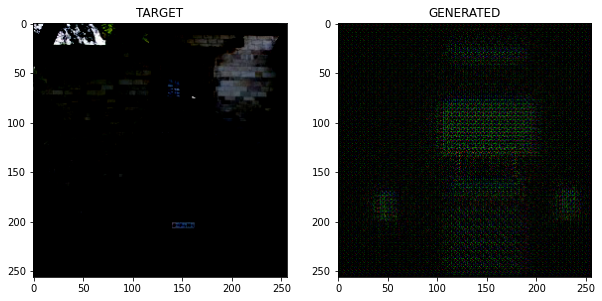

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


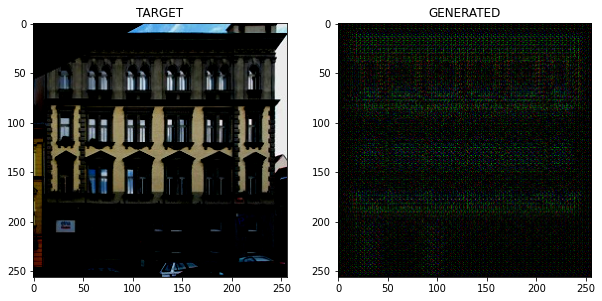

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


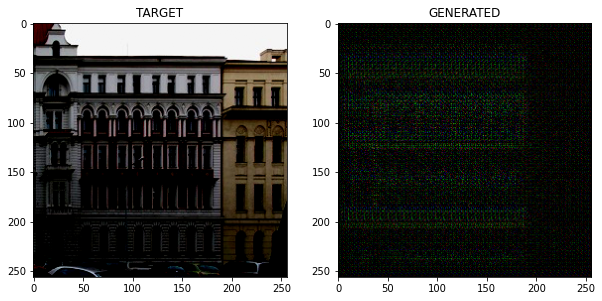

In [32]:
inputs, targets = next(iter(val_dataloader))
inputs = inputs.to(device)
generated_output = generator(inputs)

for target_image, generated_image  in zip(targets, generated_output):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(np.transpose(target_image, (1, 2, 0)))
  axs[0].set_title("TARGET")
  axs[0].grid(False)

  axs[1].imshow(np.transpose(generated_image.detach().cpu().numpy(), (1, 2, 0)))
  axs[1].set_title("GENERATED")
  axs[1].grid(False)

  plt.show()